# Batch Document Extraction with Llama Vision

Streamlined batch processing notebook using modular components.

**Features:**
- Early model loading
- Configurable output directory
- Comprehensive analytics and visualizations
- Clean, modular code structure

## 1. Imports

In [1]:
# Enable autoreload for module changes
%load_ext autoreload
%autoreload 2

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Standard library imports
import warnings
from datetime import datetime
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
from IPython.display import display, Image
from rich import print as rprint
from rich.console import Console

# Project-specific imports
from common.batch_analytics import BatchAnalytics
from common.batch_processor import BatchDocumentProcessor
from common.batch_reporting import BatchReporter
from common.batch_visualizations import BatchVisualizer
from common.evaluation_metrics import load_ground_truth
from common.extraction_parser import discover_images
from common.gpu_optimization import emergency_cleanup
from common.llama_model_loader_robust import load_llama_model_robust

print("✅ All imports loaded successfully")
print("✅ Llama batch processing modules imported successfully")
warnings.filterwarnings('ignore')

✅ All imports loaded successfully
✅ Llama batch processing modules imported successfully


## 2. Pre-emptive Memory Cleanup

**CRITICAL for V100**: Run this cell first to prevent OOM errors when switching between models.

In [2]:
# Initialize console for rich output
console = Console()# Pre-emptive V100 Memory Cleanup - Run FIRST to prevent OOM errors
rprint("[bold red]🧹 PRE-EMPTIVE V100 MEMORY CLEANUP[/bold red]")
rprint("[yellow]Clearing any existing model caches before loading...[/yellow]")
rprint("[cyan]💡 This prevents OOM errors when switching between models on V100[/cyan]")

# Emergency cleanup to ensure clean slate
emergency_cleanup(verbose=True)

rprint("[green]✅ Memory cleanup complete - ready for model loading[/green]")
rprint("[dim]📋 Next: Import modules and configure settings[/dim]")

🧹 PRE-EMPTIVE V100 MEMORY CLEANUP

Clearing any existing model caches before loading...

💡 This prevents OOM errors when switching between models on V100

🚨 Running V100 emergency GPU cleanup...
🧹 Starting V100-optimized GPU memory cleanup...
   📊 Initial GPU memory: 0.00GB allocated, 0.00GB reserved
   ✅ Final GPU memory: 0.00GB allocated, 0.00GB reserved
   💾 Memory freed: 0.00GB
✅ V100-optimized memory cleanup complete
✅ V100 emergency cleanup complete


✅ Memory cleanup complete - ready for model loading

📋 Next: Import modules and configure settings

## 3. Configuration

In [3]:
# Environment-specific base paths
ENVIRONMENT_BASES = {
    'sandbox': '/home/jovyan/nfs_share/tod',
    'efs': '/efs/shared/PoC_data'
}
base_data_path = ENVIRONMENT_BASES['sandbox']

CONFIG = {
    # Model settings
    # 'MODEL_PATH': "/efs/shared/PTM/Llama-3.2-11B-Vision-Instruct",
    'MODEL_PATH': "/home/jovyan/nfs_share/models/Llama-3.2-11B-Vision-Instruct",

    # Batch settings - Using base path for consistency
    'DATA_DIR': f'{base_data_path}/evaluation_data',
    'GROUND_TRUTH': f'{base_data_path}/evaluation_data/ground_truth.csv',
    'OUTPUT_BASE': f'{base_data_path}/output',
    'MAX_IMAGES': None,  # None for all, or set limit
    'DOCUMENT_TYPES': None,  # None for all, or ['invoice', 'receipt']
    
    # Inference and evaluation mode
    'INFERENCE_ONLY': False,  # Default: True (inference-only mode)

    # Verbosity control
    'VERBOSE': True,
    'SHOW_PROMPTS': True,

    # L40S optimization settings
    'USE_QUANTIZATION': False,
    'DEVICE_MAP': 'auto',
    'MAX_NEW_TOKENS': 2000,  # Reduced for L40S (was 4000 for V100)
    'TORCH_DTYPE': 'bfloat16',
    'LOW_CPU_MEM_USAGE': True
}

# Make GROUND_TRUTH conditional based on INFERENCE_ONLY mode
if CONFIG['INFERENCE_ONLY']:
    CONFIG['GROUND_TRUTH'] = None

# CORRECTED PROMPT CONFIG FOR LLAMA MODEL
PROMPT_CONFIG = {
    'detection_file': 'prompts/document_type_detection.yaml',
    'detection_key': 'detection',
    'extraction_files': {
        'INVOICE': 'prompts/llama_prompts.yaml',      # FIXED: Use Llama prompts
        'RECEIPT': 'prompts/llama_prompts.yaml',      # FIXED: Use Llama prompts  
        'BANK_STATEMENT': 'prompts/llama_prompts.yaml' # FIXED: Use Llama prompts
    },
    'extraction_keys': {
        'INVOICE': 'invoice',        # FIXED: Use correct document type keys
        'RECEIPT': 'receipt',        # FIXED: Use correct document type keys
        'BANK_STATEMENT': 'bank_statement'  # FIXED: Use correct document type keys
    }
}

print("✅ Configuration set up successfully")
print(f"📂 Data directory: {CONFIG['DATA_DIR']}")
print(f"📊 Ground truth: {CONFIG['GROUND_TRUTH']}")
print(f"🤖 Model path: {CONFIG['MODEL_PATH']}")
print(f"📁 Output base: {CONFIG['OUTPUT_BASE']}")
print(f"🎯 Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}")

✅ Configuration set up successfully
📂 Data directory: /home/jovyan/nfs_share/tod/evaluation_data
📊 Ground truth: /home/jovyan/nfs_share/tod/evaluation_data/ground_truth.csv
🤖 Model path: /home/jovyan/nfs_share/models/Llama-3.2-11B-Vision-Instruct
📁 Output base: /home/jovyan/nfs_share/tod/output
🎯 Mode: Evaluation mode


## 4. Output Directory Setup

In [4]:
# Setup output directories - Handle both absolute and relative paths

# Convert OUTPUT_BASE to Path and handle absolute/relative paths
OUTPUT_BASE = Path(CONFIG['OUTPUT_BASE'])
if not OUTPUT_BASE.is_absolute():
    # If relative, make it relative to current working directory
    OUTPUT_BASE = Path.cwd() / OUTPUT_BASE

BATCH_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

OUTPUT_DIRS = {
    'base': OUTPUT_BASE,
    'batch': OUTPUT_BASE / 'batch_results',
    'csv': OUTPUT_BASE / 'csv',
    'visualizations': OUTPUT_BASE / 'visualizations',
    'reports': OUTPUT_BASE / 'reports'
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

## 5. Model Loading

In [5]:
# Load model once for entire batch
rprint("[bold green]Loading model with robust multi-GPU detection...[/bold green]")

model, processor = load_llama_model_robust(
    model_path=CONFIG['MODEL_PATH'],
    use_quantization=CONFIG['USE_QUANTIZATION'],
    device_map=CONFIG['DEVICE_MAP'],
    max_new_tokens=CONFIG['MAX_NEW_TOKENS'],
    torch_dtype=CONFIG['TORCH_DTYPE'],
    low_cpu_mem_usage=CONFIG['LOW_CPU_MEM_USAGE'],
    verbose=CONFIG['VERBOSE']
)

# Model and processor will be used directly by DocumentAwareLlamaProcessor in batch processing
rprint("[bold green]✅ Model ready for document-aware processing with robust detection[/bold green]")

Loading model with robust multi-GPU detection...

🚀 Loading Llama Vision model with robust multi-GPU optimization...

Features: Smart quantization, memory management, V100 support

🔧 Configuring CUDA memory for Llama...

⚠️ Removing problematic PYTORCH_CUDA_ALLOC_CONF: expandable_segments:True
🔧 CUDA memory allocation configured: max_split_size_mb:64
💡 Using 64MB memory blocks to reduce fragmentation
📊 Initial CUDA state (Multi-GPU Total): Allocated=0.00GB, Reserved=0.00GB


🔍 Performing robust GPU memory detection...

🔍 Starting robust GPU memory detection...
📊 Detected 2 GPU(s), analyzing each device...
   GPU 0 (NVIDIA H200): 139.7GB total, 139.7GB available
   GPU 1 (NVIDIA H200): 139.7GB total, 139.7GB available

🔍 ROBUST GPU MEMORY DETECTION REPORT
✅ Success: 2/2 GPUs detected
📊 Total Memory: 279.44GB
💾 Available Memory: 279.44GB
⚡ Allocated Memory: 0.00GB
🔄 Reserved Memory: 0.00GB
📦 Fragmentation: 0.00GB
🖥️  Multi-GPU: Yes
⚖️  Balanced Distribution: Yes

📋 Per-GPU Breakdown:
   GPU 0 (NVIDIA H200): 139.7GB total, 139.7GB available (0.0% used)
   GPU 1 (NVIDIA H200): 139.7GB total, 139.7GB available (0.0% used)


📊 GPU Hardware: NVIDIA H200 (2x 140GB = 279GB total)

🏗️ Architecture: datacenter_high_memory (dynamic detection)

🎯 Model: Llama-3.2-11B-Vision (estimated need: 22GB + 6.0GB buffer)

💾 Available Memory: 279.4GB across 2 GPU(s)

💡 Memory sufficient: ✅ Yes

✅ datacenter_high_memory with 279GB - running in full precision as requested

📊 FINAL QUANTIZATION DECISION: DISABLED (full precision)

   Total GPU Memory: 279GB

   Available Memory: 279GB

Model needs: ~22GB + 6.0GB buffer for Llama-3.2-11B-Vision

   Working GPUs: 2/2

🚀 Using 16-bit precision for optimal performance

Loading Llama Vision model...

🔄 Auto-distributing model across 2 GPUs...

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Loading processor...

✅ Model and processor loaded successfully!

🔄 Multi-GPU Distribution Analysis (2 GPUs):

GPU 0 (NVIDIA H200): 9.8GB/150GB (6.5%)

GPU 1 (NVIDIA H200): 11.6GB/150GB (7.7%)

📊 Total across all GPUs: 21.3GB allocated, 21.4GB reserved, 300GB capacity

✅ Model successfully distributed across GPUs

0: 18 modules

1: 28 modules

                            🔧 Llama Vision Model Configuration                            
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Setting             ┃ Value                         ┃ Llama Status                      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Model Path          │ Llama-3.2-11B-Vision-Instruct │ ✅ Valid                          │
│ Device Placement    │ cuda:0                        │ ✅ Loaded                         │
│ Quantization Method │ 16-bit                        │ ✅ 16-bit (Performance Optimized) │
│ Data Type           │ bfloat16                      │ ✅ Recommended                    │
│ Max New Tokens      │ 2000                          │ ✅ Generation Ready               │
│ GPU Configuration   │ 2x NVIDIA H200 (300GB)        │ ✅ 300GB Total                    │
│ Model Parameters    │ 10,670,220,835                │ ✅ Loaded                         │
│ Memory Optimization │ Llama Robust                  │ ✅ V100 Compatible                │
└─────────────────────┴───────────────────────────────┴───────────────────────────────────┘

Running model compatibility test...

✅ Model compatibility test passed

Performing initial memory cleanup...

🧹 Memory cleanup completed

💾 Final state (Multi-GPU Total): Allocated=21.34GB, Reserved=21.37GB, Fragmentation=0.03GB

🎉 Llama Vision model loading and validation complete!

🔧 Llama optimizations active: 16-bit precision, memory management, vision preservation

✅ Model ready for document-aware processing with robust detection

## 6. Image Discovery

In [6]:
# Discover and filter images - Handle both absolute and relative paths

# Convert DATA_DIR to Path and handle absolute/relative paths
data_dir = Path(CONFIG['DATA_DIR'])
if not data_dir.is_absolute():
    # If relative, make it relative to current working directory
    data_dir = Path.cwd() / data_dir

# Discover images from the resolved data directory
all_images = discover_images(str(data_dir))

# Conditionally load ground truth only when not in inference-only mode
ground_truth = {}
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    # Convert GROUND_TRUTH to Path and handle absolute/relative paths
    ground_truth_path = Path(CONFIG['GROUND_TRUTH'])
    if not ground_truth_path.is_absolute():
        # If relative, make it relative to current working directory
        ground_truth_path = Path.cwd() / ground_truth_path
    
    # Load ground truth from the resolved path
    ground_truth = load_ground_truth(str(ground_truth_path), verbose=CONFIG['VERBOSE'])
    
    rprint(f"[green]✅ Ground truth loaded for {len(ground_truth)} images[/green]")
else:
    rprint("[cyan]📋 Running in inference-only mode (no ground truth required)[/cyan]")

# Apply filters (only if ground truth is available)
if CONFIG['DOCUMENT_TYPES'] and ground_truth:
    filtered = []
    for img in all_images:
        img_name = Path(img).name
        if img_name in ground_truth:
            doc_type = ground_truth[img_name].get('DOCUMENT_TYPE', '').lower()
            if any(dt.lower() in doc_type for dt in CONFIG['DOCUMENT_TYPES']):
                filtered.append(img)
    all_images = filtered

if CONFIG['MAX_IMAGES']:
    all_images = all_images[:CONFIG['MAX_IMAGES']]

rprint(f"[bold green]Ready to process {len(all_images)} images[/bold green]")
rprint(f"[cyan]Data directory: {data_dir}[/cyan]")
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    rprint(f"[cyan]Ground truth: {ground_truth_path}[/cyan]")
rprint(f"[cyan]Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}[/cyan]")
for i, img in enumerate(all_images[:5], 1):
    print(f"  {i}. {Path(img).name}")
if len(all_images) > 5:
    print(f"  ... and {len(all_images) - 5} more")

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Ground truth loaded for 9 images

Ready to process 9 images

Data directory: /home/jovyan/nfs_share/tod/evaluation_data

Ground truth: /home/jovyan/nfs_share/tod/evaluation_data/ground_truth.csv

Mode: Evaluation mode

  1. image_001.png
  2. image_002.png
  3. image_003.png
  4. image_004.png
  5. image_005.png
  ... and 4 more


## 7. Batch Processing

In [7]:
# Initialize batch processor with simplified, clean architecture
processor = BatchDocumentProcessor(
    model=model,
    processor=processor,
    prompt_config=PROMPT_CONFIG,
    ground_truth_csv=CONFIG['GROUND_TRUTH'],  # None in inference-only mode
    console=console
)

# Process batch with CONFIG verbose setting for detailed field comparison
batch_results, processing_times, document_types_found = processor.process_batch(
    all_images, verbose=CONFIG['VERBOSE']
)

# Brief summary
rprint(f"[bold green]✅ Processed {len(batch_results)} images[/bold green]")
rprint(f"[cyan]Average time: {np.mean(processing_times):.2f}s[/cyan]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Inference-only mode: No accuracy evaluation performed[/cyan]")
else:
    avg_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in batch_results if 'evaluation' in r])
    rprint(f"[cyan]Average accuracy: {avg_accuracy:.1f}%[/cyan]")

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Loaded ground truth for 9 images

🚀 Starting Batch Processing

──────────────────────────────────────────────── Batch Extraction ─────────────────────────────────────────────────

Output()

Processing [1/9]: image_001.png

🔧 Detection tokens - YAML: 200, Model config: 2000

📋 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This document is a RECEIPT, specifically a purchase receipt for Liberty Oil.

✅ Detected Document Type: RECEIPT

🧹 Cleaning memory before extraction...

📋 FIELD EXTRACTION

Creating extraction processor with 14 fields for RECEIPT

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

🔧 Using configured max_tokens: 2000 (from notebook CONFIG)

📄 RAW MODEL EXTRACTION RESPONSE:

Total response length: 3339 characters

DOCUMENT_TYPE: RECEIPT

BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: Liberty Oil
BUSINESS_ADDRESS: 481 Bourke Street, Perth WA 6000

PAYER_NAME: Robert Taylor
PAYER_ADDRESS: 243 Adelaide Street, Perth WA 6000

INVOICE_DATE: 05/08/2025

LINE_ITEM_DESCRIPTIONS: Car Wash, Coffee Large, Unleaded Petrol, Car Wash, Diesel
LINE_ITEM_QUANTITIES: 3, 1, 1, 2, 3
LINE_ITEM_PRICES: $15.00, $4.50, $1.65, $15.00, $1.70
LINE_ITEM_TOTAL_PRICES: $45.00, $4.50, $1.65, $30.00, $5.10

IS_GST_INCLUDED: true
GST_AMOUNT: $8.62
TOTAL_AMOUNT: $94.87

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: RECEIPT

SUPPLIER_NAME: Liberty Oil

BUSINESS_ADDRESS: 481 Bourke Street, Perth WA 6000

PAYER_NAME: Robert Taylor

PAYER_ADDRESS: 243 Adelaide Street, Perth WA 6000

INVOICE_DATE: 05/08/2025

LINE_ITEM_DESCRIPTIONS: Car Wash, Coffee Large, Unleaded Petrol, Car Wash, Diesel

LINE_ITEM_QUANTITIES: 3, 1, 1, 2, 3

LINE_ITEM_PRICES: $15.00, $4.50, $1.65, $15.00, $1.70

LINE_ITEM_TOTAL_PRICES: $45.00, $4.50, $1.65, $30.00, $5.10

IS_GST_INCLUDED: true

GST_AMOUNT: $8.62

TOTAL_AMOUNT: $94.87

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ Extracted 13 fields from image_001.png

✓ Accuracy: 64.3% for image_001.png

Processing [2/9]: image_002.png

🔧 Detection tokens - YAML: 200, Model config: 2000

📋 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This is a RECEIPT.

✅ Detected Document Type: RECEIPT

🧹 Cleaning memory before extraction...

📋 FIELD EXTRACTION

Creating extraction processor with 14 fields for RECEIPT

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

🔧 Using configured max_tokens: 2000 (from notebook CONFIG)

📄 RAW MODEL EXTRACTION RESPONSE:

Total response length: 3412 characters

DOCUMENT_TYPE: RECEIPT

BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: Ampol Limited
BUSINESS_ADDRESS: 680 Collins Street, Darwin NT 0800

PAYER_NAME: Sophie Martin
PAYER_ADDRESS: 487 Collins Street, Hobart TAS 7000

INVOICE_DATE: 18/07/2025

LINE_ITEM_DESCRIPTIONS: Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium 
Unleaded
LINE_ITEM_QUANTITIES: 1 | 1 | 2 | 2 | 2 | 2
LINE_ITEM_PRICES: $4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75
LINE_ITEM_TOTAL_PRICES: $4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50

IS_GST_INCLUDED: true
GST_AMOUNT: $5.20
TOTAL_AMOUNT: $57.15

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: RECEIPT

SUPPLIER_NAME: Ampol Limited

BUSINESS_ADDRESS: 680 Collins Street, Darwin NT 0800

PAYER_NAME: Sophie Martin

PAYER_ADDRESS: 487 Collins Street, Hobart TAS 7000

INVOICE_DATE: 18/07/2025

LINE_ITEM_DESCRIPTIONS: Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium 
Unleaded

LINE_ITEM_QUANTITIES: 1 | 1 | 2 | 2 | 2 | 2

LINE_ITEM_PRICES: $4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75

LINE_ITEM_TOTAL_PRICES: $4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50

IS_GST_INCLUDED: true

GST_AMOUNT: $5.20

TOTAL_AMOUNT: $57.15

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ Extracted 13 fields from image_002.png

✓ Accuracy: 85.7% for image_002.png

Processing [3/9]: image_003.png

🔧 Detection tokens - YAML: 200, Model config: 2000

📋 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This is a bank statement.

✅ Detected Document Type: BANK_STATEMENT

🧹 Cleaning memory before extraction...

🔍 Analyzing bank statement structure: image_003.png

🤖 Using VLM for structure analysis...

📋 VLM response: 'FLAT'

🧠 Analysis: date_indicators=False, flat_indicators=True

📊 Triggered flat indicators: ['FLAT']

📋 Classification Result: FLAT

Description: Continuous table format with column headers

💡 Will use flat table extraction prompt

🏦 Bank statement structure: flat

📁 Using prompt: llama_prompts.yaml (bank_statement_flat)

📋 FIELD EXTRACTION

Creating extraction processor with 7 fields for BANK_STATEMENT

Fields: DOCUMENT_TYPE, STATEMENT_DATE_RANGE, LINE_ITEM_DESCRIPTIONS... (7 total)

🔧 Using configured max_tokens: 2000 (from notebook CONFIG)

📄 RAW MODEL EXTRACTION RESPONSE:

Total response length: 1928 characters

**DOCUMENT_TYPE**: STATEMENT
**STATEMENT_DATE_RANGE**: 03/05/2025 to 10/05/2025
**LINE_ITEM_DESCRIPTIONS**: ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES EXP | 
DIRECT CREDIT SALARY | ATM WITHDRAWAL ANZ ATM | EFTPOS PURCHASE COLES EXP | INTEREST PAYMENT | ATM WITHDRAWAL ANZ 
ATM
**TRANSACTION_DATES**: 03/05/2025 | 04/05/2025 | 05/05/2025 | 06/05/2025 | 07/05/2025 | 08/05/2025 | 09/05/2025 | 
10/05/2025
**TRANSACTION_AMOUNTS_PAID**: $288.03 | $22.50 | $114.66 | $187.59 | $112.50 | $5.16 | $146.72
**TRANSACTION_AMOUNTS_RECEIVED**: $3497.47 | $13344.94 | $13230.27 | $16727.74 | $16540.15 | $16427.65 | $16432.81 
| $16286.08
**ACCOUNT_BALANCE**: $13387.44 | $13344.94 | $13230.27 | $16727.74 | $16540.15 | $16427.65 | $16432.81 | $16286.08

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: STATEMENT

STATEMENT_DATE_RANGE: 03/05/2025 to 10/05/2025

LINE_ITEM_DESCRIPTIONS: ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES EXP | 
DIRECT CREDIT SA...

TRANSACTION_DATES: 03/05/2025 | 04/05/2025 | 05/05/2025 | 06/05/2025 | 07/05/2025 | 08/05/2025 | 09/05/2025 | 
10/05/202...

TRANSACTION_AMOUNTS_PAID: $288.03 | $22.50 | $114.66 | $187.59 | $112.50 | $5.16 | $146.72

TRANSACTION_AMOUNTS_RECEIVED: $3497.47 | $13344.94 | $13230.27 | $16727.74 | $16540.15 | $16427.65 | $16432.81 | 
$16286.08

ACCOUNT_BALANCE: $13387.44 | $13344.94 | $13230.27 | $16727.74 | $16540.15 | $16427.65 | $16432.81 | $16286.08

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🧮 Applying mathematical enhancement for bank statement

📊 Analyzing 8 transactions with pandas

⚠️ Description suggests DEBIT but VLM extracted as CREDIT - correcting

🔍 MATHEMATICAL CORRECTION DEBUG - COMPLETE CORRECTED DATAFRAME

All columns showing mathematical correction results:

Pos 0: 03/05/2025 | ONLINE PURCHASE AMAZON AU | Balance: $13387.44 | Change: NaN | VLM_PAID: 288.03 | VLM_RECV: 
3497.47 | FINAL_PAID: $288.03 | FINAL_RECV: $3497.47

Pos 1: 04/05/2025 | EFTPOS PURCHASE COLES EXP | Balance: $13344.94 | Change: -42.5 | VLM_PAID: 22.5 | VLM_RECV: 
13344.94 | FINAL_PAID: $22.50 | FINAL_RECV: $13344.94

Pos 2: 05/05/2025 | EFTPOS PURCHASE COLES EXP | Balance: $13230.27 | Change: -114.67000000000007 | VLM_PAID: 114.66
| VLM_RECV: 13230.27 | FINAL_PAID: $114.66 | FINAL_RECV: $13230.27

Pos 3: 06/05/2025 | DIRECT CREDIT SALARY | Balance: $16727.74 | Change: 3497.470000000001 | VLM_PAID: 187.59 | 
VLM_RECV: 16727.74 | FINAL_PAID: $187.59 | FINAL_RECV: $16727.74

Pos 4: 07/05/2025 | ATM WITHDRAWAL ANZ ATM | Balance: $16540.15 | Change: -187.59000000000015 | VLM_PAID: 112.5 | 
VLM_RECV: 16540.15 | FINAL_PAID: $112.50 | FINAL_RECV: $16540.15

Pos 5: 08/05/2025 | EFTPOS PURCHASE COLES EXP | Balance: $16427.65 | Change: -112.5 | VLM_PAID: 5.16 | VLM_RECV: 
16427.65 | FINAL_PAID: $5.16 | FINAL_RECV: $16427.65

Pos 6: 09/05/2025 | INTEREST PAYMENT | Balance: $16432.81 | Change: 5.1599999999998545 | VLM_PAID: 146.72 | 
VLM_RECV: 16432.81 | FINAL_PAID: $146.72 | FINAL_RECV: $16432.81

Pos 7: 10/05/2025 | ATM WITHDRAWAL ANZ ATM | Balance: $16286.08 | Change: -146.73000000000138 | VLM_PAID: NaN | 
VLM_RECV: 16286.08 | FINAL_PAID: $16286.08 | FINAL_RECV: NOT_FOUND

📊 Pandas-Based Bank Statement Analysis

📋 Transactions: 8

📤 Total Debits: $17163.24

📥 Total Credits: $96201.03

💰 Net Change: $79037.79

🔍 Balance Validation: ✅ PASSED

📊 Data Sources and Corrections:

   • 4.0 VLM amounts (correctly classified)

   • 4.0 VLM amounts (classification corrected)

   • 0 mathematical calculations (VLM gaps filled)

💡 VLM Amount Accuracy: -1902.8% average

📅 All transactions with validation:

  03/05/2025: DEBIT $288.03 [VLM→CORRECTED] (0.8)

  04/05/2025: DEBIT $22.50 [VLM✓ 53%] (0.9)

  05/05/2025: DEBIT $114.66 [VLM✓ 100%] (0.9)

  06/05/2025: DEBIT $187.59 [VLM→CORRECTED 5%] (0.8)

  07/05/2025: DEBIT $112.50 [VLM✓ 60%] (0.9)

  08/05/2025: DEBIT $5.16 [VLM✓ 5%] (0.9)

  09/05/2025: DEBIT $146.72 [VLM→CORRECTED -2643%] (0.8)

  10/05/2025: DEBIT $16286.08 [VLM→CORRECTED -10899%] (0.8)

✅ Mathematical enhancement completed successfully

🎯 Filtering to debit-only transactions for evaluation

✓ Extracted 7 fields from image_003.png

✓ Mathematical analysis: 8 transactions calculated

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Accuracy: 20.0% for image_003.png

Processing [4/9]: image_004.png

🔧 Detection tokens - YAML: 200, Model config: 2000

📋 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This document is a receipt, as it includes details of a purchase made at Liberty Oil, such as the date, time, items
purchased, and total amount paid.

✅ Detected Document Type: RECEIPT

🧹 Cleaning memory before extraction...

📋 FIELD EXTRACTION

Creating extraction processor with 14 fields for RECEIPT

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

🔧 Using configured max_tokens: 2000 (from notebook CONFIG)

📄 RAW MODEL EXTRACTION RESPONSE:

Total response length: 3291 characters

DOCUMENT_TYPE: RECEIPT

BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: Liberty Oil
BUSINESS_ADDRESS: 993 Pitt Street, Darwin NT 0800

PAYER_NAME: William Harris
PAYER_ADDRESS: 52 Bourke Street, Darwin NT 0800

INVOICE_DATE: 19/07/2025

LINE_ITEM_DESCRIPTIONS: Premium Unleaded | Diesel | Unleaded Petrol
LINE_ITEM_QUANTITIES: 1 | 2 | 3
LINE_ITEM_PRICES: $1.75 | $1.70 | $1.65
LINE_ITEM_TOTAL_PRICES: $1.75 | $3.40 | $4.95

IS_GST_INCLUDED: true
GST_AMOUNT: $1.01
TOTAL_AMOUNT: $11.11

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: RECEIPT

SUPPLIER_NAME: Liberty Oil

BUSINESS_ADDRESS: 993 Pitt Street, Darwin NT 0800

PAYER_NAME: William Harris

PAYER_ADDRESS: 52 Bourke Street, Darwin NT 0800

INVOICE_DATE: 19/07/2025

LINE_ITEM_DESCRIPTIONS: Premium Unleaded | Diesel | Unleaded Petrol

LINE_ITEM_QUANTITIES: 1 | 2 | 3

LINE_ITEM_PRICES: $1.75 | $1.70 | $1.65

LINE_ITEM_TOTAL_PRICES: $1.75 | $3.40 | $4.95

IS_GST_INCLUDED: true

GST_AMOUNT: $1.01

TOTAL_AMOUNT: $11.11

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ Extracted 13 fields from image_004.png

✓ Accuracy: 92.9% for image_004.png

Processing [5/9]: image_005.png

🔧 Detection tokens - YAML: 200, Model config: 2000

📋 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This document is an invoice, specifically a tax invoice, which includes details such as the business name, address,
and contact information, as well as a list of items purchased, their quantities, prices, and total cost.

✅ Detected Document Type: INVOICE

🧹 Cleaning memory before extraction...

📋 FIELD EXTRACTION

Creating extraction processor with 14 fields for INVOICE

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

🔧 Using configured max_tokens: 2000 (from notebook CONFIG)

📄 RAW MODEL EXTRACTION RESPONSE:

Total response length: 3186 characters

DOCUMENT_TYPE: INVOICE

BUSINESS_ABN: 73 154 562 747
SUPPLIER_NAME: Aussie Office Supplies Pty Ltd
BUSINESS_ADDRESS: 123 Collins Street, Melbourne VIC 3000

PAYER_NAME: Perth Building Materials
PAYER_ADDRESS: 456 George Street, Sydney NSW 2000

INVOICE_DATE: 06/08/2025

LINE_ITEM_DESCRIPTIONS: Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand
LINE_ITEM_QUANTITIES: 3 | 3 | 2 | 3 | 1
LINE_ITEM_PRICES: $490.12 | $38.84 | $431.58 | $138.58 | $1968.24
LINE_ITEM_TOTAL_PRICES: $1470.35 | $116.53 | $863.17 | $415.74 | $1968.24

IS_GST_INCLUDED: true
GST_AMOUNT: $439.46
TOTAL_AMOUNT: $4834.03

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: INVOICE

BUSINESS_ABN: 73 154 562 747

SUPPLIER_NAME: Aussie Office Supplies Pty Ltd

BUSINESS_ADDRESS: 123 Collins Street, Melbourne VIC 3000

PAYER_NAME: Perth Building Materials

PAYER_ADDRESS: 456 George Street, Sydney NSW 2000

INVOICE_DATE: 06/08/2025

LINE_ITEM_DESCRIPTIONS: Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand

LINE_ITEM_QUANTITIES: 3 | 3 | 2 | 3 | 1

LINE_ITEM_PRICES: $490.12 | $38.84 | $431.58 | $138.58 | $1968.24

LINE_ITEM_TOTAL_PRICES: $1470.35 | $116.53 | $863.17 | $415.74 | $1968.24

IS_GST_INCLUDED: true

GST_AMOUNT: $439.46

TOTAL_AMOUNT: $4834.03

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ Extracted 14 fields from image_005.png

✓ Accuracy: 100.0% for image_005.png

[5/9] image_005.png: INVOICE - Accuracy: 100.0% - Time: 8.20s

Processing [6/9]: image_006.png

🔧 Detection tokens - YAML: 200, Model config: 2000

📋 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This document is an INVOICE.

✅ Detected Document Type: INVOICE

🧹 Cleaning memory before extraction...

📋 FIELD EXTRACTION

Creating extraction processor with 14 fields for INVOICE

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

🔧 Using configured max_tokens: 2000 (from notebook CONFIG)

📄 RAW MODEL EXTRACTION RESPONSE:

Total response length: 3283 characters

DOCUMENT_TYPE: INVOICE

BUSINESS_ABN: 26 668 321 195
SUPPLIER_NAME: Maritime Mechanics
BUSINESS_ADDRESS: 1/92 Watt Road, Mornington, VIC 3931 - P: (03) 5973 4755

PAYER_NAME: Tod Nestor
PAYER_ADDRESS: 29 Frederick Street, FERNTREE GULLY VIC 3156

INVOICE_DATE: 27/08/2025

LINE_ITEM_DESCRIPTIONS: VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To Complete |
Freight - Parts In
LINE_ITEM_QUANTITIES: 1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0
LINE_ITEM_PRICES: $356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00
LINE_ITEM_TOTAL_PRICES: $356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1,530.00 | $40.00

IS_GST_INCLUDED: true
GST_AMOUNT: $374.98
TOTAL_AMOUNT: $4,124.82

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: INVOICE

BUSINESS_ABN: 26 668 321 195

SUPPLIER_NAME: Maritime Mechanics

BUSINESS_ADDRESS: 1/92 Watt Road, Mornington, VIC 3931 - P: (03) 5973 4755

PAYER_NAME: Tod Nestor

PAYER_ADDRESS: 29 Frederick Street, FERNTREE GULLY VIC 3156

INVOICE_DATE: 27/08/2025

LINE_ITEM_DESCRIPTIONS: VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To Complete
| Freight ...

LINE_ITEM_QUANTITIES: 1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0

LINE_ITEM_PRICES: $356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00

LINE_ITEM_TOTAL_PRICES: $356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1,530.00 | $40.00

IS_GST_INCLUDED: true

GST_AMOUNT: $374.98

TOTAL_AMOUNT: $4,124.82

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ Extracted 14 fields from image_006.png

✓ Accuracy: 92.9% for image_006.png

Processing [7/9]: image_007.png

🔧 Detection tokens - YAML: 200, Model config: 2000

📋 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This is an invoice.

✅ Detected Document Type: INVOICE

🧹 Cleaning memory before extraction...

📋 FIELD EXTRACTION

Creating extraction processor with 14 fields for INVOICE

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

🔧 Using configured max_tokens: 2000 (from notebook CONFIG)

📄 RAW MODEL EXTRACTION RESPONSE:

Total response length: 3219 characters

DOCUMENT_TYPE: INVOICE

BUSINESS_ABN: 64 086 174 781
SUPPLIER_NAME: Telstra Limited
BUSINESS_ADDRESS: ABN 64 086 174 781
29 Frederick Street
FERNTREE GULLY VIC 3156

PAYER_NAME: Mr Maurice Nestor
PAYER_ADDRESS: 29 Frederick Street
FERNTREE GULLY VIC 3156

INVOICE_DATE: 16 Jul 2025

LINE_ITEM_DESCRIPTIONS: Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data service 0409 
760 513 | Mobile data service 0428 992 418
LINE_ITEM_QUANTITIES: 1 | 1 | 1 | 1
LINE_ITEM_PRICES: $45.00 | $30.00 | $25.00 | $20.00
LINE_ITEM_TOTAL_PRICES: $45.00 | $30.00 | $25.00 | $20.00

IS_GST_INCLUDED: true
GST_AMOUNT: $10.91
TOTAL_AMOUNT: $120.00

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: INVOICE

BUSINESS_ABN: 64 086 174 781

SUPPLIER_NAME: Telstra Limited

BUSINESS_ADDRESS: ABN 64 086 174 781

PAYER_NAME: Mr Maurice Nestor

PAYER_ADDRESS: 29 Frederick Street

INVOICE_DATE: 16 Jul 2025

LINE_ITEM_DESCRIPTIONS: Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data service 0409
760 513 | ...

LINE_ITEM_QUANTITIES: 1 | 1 | 1 | 1

LINE_ITEM_PRICES: $45.00 | $30.00 | $25.00 | $20.00

LINE_ITEM_TOTAL_PRICES: $45.00 | $30.00 | $25.00 | $20.00

IS_GST_INCLUDED: true

GST_AMOUNT: $10.91

TOTAL_AMOUNT: $120.00

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ Extracted 14 fields from image_007.png

✓ Accuracy: 78.6% for image_007.png

Processing [8/9]: image_008.png

🔧 Detection tokens - YAML: 200, Model config: 2000

📋 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This is a bank statement, so the correct answer is: **BANK_STATEMENT**.

✅ Detected Document Type: BANK_STATEMENT

🧹 Cleaning memory before extraction...

🔍 Analyzing bank statement structure: image_008.png

🤖 Using VLM for structure analysis...

📋 VLM response: 'FLAT'

🧠 Analysis: date_indicators=False, flat_indicators=True

📊 Triggered flat indicators: ['FLAT']

📋 Classification Result: FLAT

Description: Continuous table format with column headers

💡 Will use flat table extraction prompt

🏦 Bank statement structure: flat

📁 Using prompt: llama_prompts.yaml (bank_statement_flat)

📋 FIELD EXTRACTION

Creating extraction processor with 7 fields for BANK_STATEMENT

Fields: DOCUMENT_TYPE, STATEMENT_DATE_RANGE, LINE_ITEM_DESCRIPTIONS... (7 total)

🔧 Using configured max_tokens: 2000 (from notebook CONFIG)

📄 RAW MODEL EXTRACTION RESPONSE:

Total response length: 4891 characters

...[truncated\]...MACY BRISBANE QLD
* Card Purchase CHEMIST WAREHOUSE DISCOUNT Richmo...
* Fortnightly Pay ATO PAYROLL 91032P35687918
* PAY RUN ACME CORP PTY LTD 99584P07785218
* Salary Payment ATO 30175P32361415
* Online Purchase amazon.com.au AUS
* Salary Payment ATO 28773P16041610
* Transfer To Vicks Account NetBank 54381P90841102
* Salary Payment ATO 94514P80490207
* Transfer To Western Port Marina NetBank From Tod
* Subscription Netflix 33588P77385123
* Contactless Payment Cinema CAIRNS QLD
* Auto Payment UTILITIES Red Energy 15107P21771655
* Contactless Payment Restaurant MACKAY QLD
* Fortnightly Pay ATO PAYROLL 36358P70254998
* Centrelink Payment JobSeeker 59392P56090878
* International Transaction Fee
* Equipment Purchase OfficeMax Australia 13554P45...
* International ATM USA USD
* Dividend Payment PREMIUM CORP PTY LTD 7353SP419...
* Invoice Payment HARVEY NORMAN FLAGSHIP PTY LTD...
* Online Purchase ebay.com.au AUS
* Subscription Spotify Monthly 15369P58427775
* International Transaction Fee
* Business Expense IT Equipment 66969P86141679
* Auto Payment UTILITIES Energy Australia 47683P7...
* Auto Payment UTILITIES Red Energy 81338P61572286

**TRANSACTION_DATES:**

* 07/09/2025 | 08/09/2025 | 04/09/2025 | 03/09/2025 | 03/09/2025 | 02/09/2025 | 02/09/2025 | 01/09/2025 | 
01/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 29/08/2025 | 27/08/2025 | 27/08/2025 | 26/08/2025 | 24/08/2025 
| 23/08/2025 | 22/08/2025 | 20/08/2025 | 20/08/2025 | 20/08/2025 | 19/08/2025 | 18/08/2025 | 18/08/2025 | 
17/08/2025 | 14/08/2025 | 14/08/2025 | 13/08/2025 | 13/08/2025 | 11/08/2025 | 11/08/2025 | 10/08/2025 | 10/08/2025 
| 09/08/2025 | 06/08/2025 | 06/08/2025 | 09/08/2025

**TRANSACTION_AMOUNTS_PAID:**

$322.18 | $64.33 | $649.79 | $1365.43 | $199.17 | $45.04 | $257.50 | $4449.44 | $37.68 | $2457.87 | $270.31 | 
$1957.09 | $221.60 | $222.56 | $5679.21 | $4455.46 | $7951.93 | $6013.70 | $2345.10 | $728.48 | $201.14 | $211.28 |
$33.24 | $145.70 | $7201.19 | $2241.39 | $27.06 | $478.86 | $200.71 | $229.39 | $257.95 | $166.22 | $33.83 | $62.18
| $91.04 | $389.57

**TRANSACTION_AMOUNTS_RECEIVED:**

$48890.58 | $49212.76 | $49277.09 | $4926.68 | $51312.57 | $61511.48 | $43405.77 | $43440.81 | $43708.31 | 
$39296.85 | $41754.72 | $42025.03 | $43882.12 | $44203.72 | $44426.28 | $38747.07 | $34291.61 | $26339.68 | 
$20423.46 | $20409.76 | $22754.86 | $19213.59 | $19940.07 | $2041.21 | $20352.49 | $20385.73 | $20531.43 | 
$13330.24 | $11088.85 | $11115.91 | $11594.77 | $11855.48 | $5460.39 | $5899.73 | $9133.98 | $6167.78 | $6792.06 | 
$6884.90

**ACCOUNT_BALANCE:**

$48890.58 | $49212.76 | $49277.09 | $4926.68 | $51312.57 | $61511.48 | $43405.77 | $43440.81 | $43708.31 | 
$39296.85 | $41754.72 | $42025.03 | $43882.12 | $44203.72 | $44426.28 | $38747.07 | $34291.61 | $26339.68 | 
$20423.46 | $20409.76 | $22754.86 | $19213.59 | $19940.07 | $2041.21 | $20352.49 | $20385.73 | $20531.43 | 
$13330.24 | $11088.85 | $11115.91 | $11594.77 | $5460.39 | $5899.73 | $9133.98 | $6167.78 | $6792.06 | $6884.90

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: STATEMENT

STATEMENT_DATE_RANGE: 08/08/2025 to 07/09/2025

LINE_ITEM_DESCRIPTIONS: EFTPOS Cash Out PRICELINE PHARMACY MACKAY QLD | EFTPOS Purchase OFFICEWORKS BUSINESS 
ROCKHAMPTO... |...

TRANSACTION_DATES: * 07/09/2025 | 08/09/2025 | 04/09/2025 | 03/09/2025 | 03/09/2025 | 02/09/2025 | 02/09/2025 | 
01/09/2...

TRANSACTION_AMOUNTS_PAID: $322.18 | $64.33 | $649.79 | $1365.43 | $199.17 | $45.04 | $257.50 | $4449.44 | $37.68 
| $2457.87 | ...

TRANSACTION_AMOUNTS_RECEIVED: $48890.58 | $49212.76 | $49277.09 | $4926.68 | $51312.57 | $61511.48 | $43405.77 | 
$43440.81 | $4370...

ACCOUNT_BALANCE: $48890.58 | $49212.76 | $49277.09 | $4926.68 | $51312.57 | $61511.48 | $43405.77 | $43440.81 | 
$4370...

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🧮 Applying mathematical enhancement for bank statement

📊 Analyzing 37 transactions with pandas

⚠️ Description suggests DEBIT but VLM extracted as CREDIT - correcting

🔍 MATHEMATICAL CORRECTION DEBUG - COMPLETE CORRECTED DATAFRAME

All columns showing mathematical correction results:

Pos 0: 08/09/2025 | EFTPOS Cash Out PRICELINE PHARMACY MACKA... | Balance: $48890.58 | Change: -322.1800000000003 |
VLM_PAID: 322.18 | VLM_RECV: 48890.58 | FINAL_PAID: $322.18 | FINAL_RECV: $48890.58

Pos 1: 04/09/2025 | EFTPOS Purchase OFFICEWORKS BUSINESS ROC... | Balance: $49212.76 | Change: -64.32999999999447 |
VLM_PAID: 64.33 | VLM_RECV: 49212.76 | FINAL_PAID: $64.33 | FINAL_RECV: $49212.76

Pos 2: 03/09/2025 | Mortgage Repayment MORT 0103P16754533 NA... | Balance: $49277.09 | Change: 44350.409999999996 |
VLM_PAID: 649.79 | VLM_RECV: 49277.09 | FINAL_PAID: $649.79 | FINAL_RECV: $49277.09

Pos 3: 03/09/2025 | OSKO Payment to MIKE CHEN 809845773133 | Balance: $4926.68 | Change: -46385.89 | VLM_PAID: 
1365.43 | VLM_RECV: 4926.68 | FINAL_PAID: $1365.43 | FINAL_RECV: $4926.68

Pos 4: 02/09/2025 | Direct Debit 15395P41608293 MWF 42730 | Balance: $51312.57 | Change: -10198.910000000003 | 
VLM_PAID: 199.17 | VLM_RECV: 51312.57 | FINAL_PAID: $199.17 | FINAL_RECV: $51312.57

Pos 5: 02/09/2025 | Salary Payment ATO 28782P6782109 | Balance: $61511.48 | Change: 18070.670000000006 | VLM_PAID: 
45.04 | VLM_RECV: 61511.48 | FINAL_PAID: $45.04 | FINAL_RECV: $61511.48

Pos 6: 01/09/2025 | DD INSURANCE ACME CORP PTY LTD 823219421... | Balance: $43405.77 | Change: 4108.919999999998 | 
VLM_PAID: 257.5 | VLM_RECV: 43405.77 | FINAL_PAID: $257.50 | FINAL_RECV: $43405.77

Pos 7: 01/09/2025 | Auto Payment UTILITIES AGL 78479A0P85943... | Balance: $43440.81 | Change: -267.5 | VLM_PAID: 
4449.44 | VLM_RECV: 43440.81 | FINAL_PAID: $4449.44 | FINAL_RECV: $43440.81

Pos 8: 01/09/2025 | DIRECT CREDIT SALARY 6080P67812986 | Balance: $43708.31 | Change: 302.5400000000009 | VLM_PAID:
37.68 | VLM_RECV: 43708.31 | FINAL_PAID: $37.68 | FINAL_RECV: $43708.31

Pos 9: 31/08/2025 | BPAY Payment BILLER60279 CRN 9813018480 | Balance: $39296.85 | Change: -2457.8700000000026 | 
VLM_PAID: 2457.87 | VLM_RECV: 39296.85 | FINAL_PAID: $2457.87 | FINAL_RECV: $39296.85

Pos 10: 29/08/2025 | Professional Services Red Energy 98073P3... | Balance: $41754.72 | Change: -270.3099999999977 
| VLM_PAID: 270.31 | VLM_RECV: 41754.72 | FINAL_PAID: $270.31 | FINAL_RECV: $41754.72

Pos 11: 29/08/2025 | Card Purchase RED ROOSTER Paramatta SA | Balance: $42025.03 | Change: -1857.0900000000038 | 
VLM_PAID: 1957.09 | VLM_RECV: 42025.03 | FINAL_PAID: $1957.09 | FINAL_RECV: $42025.03

Pos 12: 27/08/2025 | Credit Card Payment CC 72599P33283283298 | Balance: $43882.12 | Change: -321.59999999999854 | 
VLM_PAID: 221.6 | VLM_RECV: 43882.12 | FINAL_PAID: $221.60 | FINAL_RECV: $43882.12

Pos 13: 27/08/2025 | EFTPOS Cash Out PRICELINE PHARMACY BRISB... | Balance: $44203.72 | Change: -222.55999999999767
| VLM_PAID: 222.56 | VLM_RECV: 44203.72 | FINAL_PAID: $222.56 | FINAL_RECV: $44203.72

Pos 14: 26/08/2025 | Card Purchase CHEMIST WAREHOUSE DISCOUNT... | Balance: $44426.28 | Change: 5679.209999999999 |
VLM_PAID: 5679.21 | VLM_RECV: 44426.28 | FINAL_PAID: $5679.21 | FINAL_RECV: $44426.28

Pos 15: 24/08/2025 | Fortnightly Pay ATO PAYROLL 91032P356879... | Balance: $38747.07 | Change: 4455.459999999999 |
VLM_PAID: 4455.46 | VLM_RECV: 38747.07 | FINAL_PAID: $4455.46 | FINAL_RECV: $38747.07

Pos 16: 23/08/2025 | PAY RUN ACME CORP PTY LTD 99584P07785218 | Balance: $34291.61 | Change: 7951.93 | VLM_PAID: 
7951.93 | VLM_RECV: 34291.61 | FINAL_PAID: $7951.93 | FINAL_RECV: $34291.61

Pos 17: 22/08/2025 | Salary Payment ATO 30175P32361415 | Balance: $26339.68 | Change: 5916.220000000001 | VLM_PAID:
6013.7 | VLM_RECV: 26339.68 | FINAL_PAID: $6013.70 | FINAL_RECV: $26339.68

Pos 18: 20/08/2025 | Online Purchase amazon.com.au AUS | Balance: $20423.46 | Change: -2331.4000000000015 | 
VLM_PAID: 2345.1 | VLM_RECV: 20423.46 | FINAL_PAID: $2345.10 | FINAL_RECV: $20423.46

Pos 19: 20/08/2025 | Salary Payment ATO 28773P16041610 | Balance: $20409.76 | Change: 1196.1699999999983 | 
VLM_PAID: 728.48 | VLM_RECV: 20409.76 | FINAL_PAID: $728.48 | FINAL_RECV: $20409.76

Pos 20: 20/08/2025 | Transfer To Vicks Account NetBank 54381P... | Balance: $22754.86 | Change: 2345.100000000002 |
VLM_PAID: 201.14 | VLM_RECV: 22754.86 | FINAL_PAID: $201.14 | FINAL_RECV: $22754.86

Pos 21: 19/08/2025 | Salary Payment ATO 94514P80490207 | Balance: $19213.59 | Change: -726.4799999999996 | 
VLM_PAID: 211.28 | VLM_RECV: 19213.59 | FINAL_PAID: $211.28 | FINAL_RECV: $19213.59

Pos 22: 18/08/2025 | Transfer To Western Port Marina NetBank ... | Balance: $19940.07 | Change: 17898.86 | 
VLM_PAID: 33.24 | VLM_RECV: 19940.07 | FINAL_PAID: $33.24 | FINAL_RECV: $19940.07

Pos 23: 18/08/2025 | Subscription Netflix 33588P77385123 | Balance: $2041.21 | Change: -18311.280000000002 | 
VLM_PAID: 145.7 | VLM_RECV: 2041.21 | FINAL_PAID: $145.70 | FINAL_RECV: $2041.21

Pos 24: 17/08/2025 | Contactless Payment Cinema CAIRNS QLD | Balance: $20352.49 | Change: -33.23999999999796 | 
VLM_PAID: 7201.19 | VLM_RECV: 20352.49 | FINAL_PAID: $7201.19 | FINAL_RECV: $20352.49

Pos 25: 14/08/2025 | Auto Payment UTILITIES Red Energy 15107P... | Balance: $20385.73 | Change: -145.70000000000073
| VLM_PAID: 2241.39 | VLM_RECV: 20385.73 | FINAL_PAID: $2241.39 | FINAL_RECV: $20385.73

Pos 26: 14/08/2025 | Contactless Payment Restaurant MACKAY QL... | Balance: $20531.43 | Change: 7201.1900000000005 
| VLM_PAID: 27.06 | VLM_RECV: 20531.43 | FINAL_PAID: $27.06 | FINAL_RECV: $20531.43

Pos 27: 13/08/2025 | Fortnightly Pay ATO PAYROLL 36358P702549... | Balance: $13330.24 | Change: 2241.3899999999994 
| VLM_PAID: 478.86 | VLM_RECV: 13330.24 | FINAL_PAID: $478.86 | FINAL_RECV: $13330.24

Pos 28: 13/08/2025 | Centrelink Payment JobSeeker 59392P56090... | Balance: $11088.85 | Change: -27.05999999999949 
| VLM_PAID: 200.71 | VLM_RECV: 11088.85 | FINAL_PAID: $200.71 | FINAL_RECV: $11088.85

Pos 29: 11/08/2025 | International Transaction Fee | Balance: $11115.91 | Change: -478.8600000000006 | VLM_PAID: 
229.39 | VLM_RECV: 11115.91 | FINAL_PAID: $229.39 | FINAL_RECV: $11115.91

Pos 30: 11/08/2025 | Equipment Purchase OfficeMax Australia 1... | Balance: $11594.77 | Change: 6134.38 | VLM_PAID:
257.95 | VLM_RECV: 11594.77 | FINAL_PAID: $257.95 | FINAL_RECV: $11594.77

Pos 31: 10/08/2025 | International ATM USA USD | Balance: $5460.39 | Change: -439.33999999999924 | VLM_PAID: 166.22
| VLM_RECV: 11855.48 | FINAL_PAID: $166.22 | FINAL_RECV: $11855.48

Pos 32: 10/08/2025 | Dividend Payment PREMIUM CORP PTY LTD 73... | Balance: $5899.73 | Change: -3234.25 | VLM_PAID:
33.83 | VLM_RECV: 5460.39 | FINAL_PAID: $33.83 | FINAL_RECV: $5460.39

Pos 33: 09/08/2025 | Invoice Payment HARVEY NORMAN FLAGSHIP P... | Balance: $9133.98 | Change: 2249.08 | VLM_PAID: 
62.18 | VLM_RECV: 5899.73 | FINAL_PAID: $62.18 | FINAL_RECV: $5899.73

Pos 34: 06/08/2025 | Online Purchase ebay.com.au AUS | Balance: $6167.78 | Change: -624.2800000000007 | VLM_PAID: 
91.04 | VLM_RECV: 9133.98 | FINAL_PAID: $91.04 | FINAL_RECV: $9133.98

Pos 35: 06/08/2025 | Subscription Spotify Monthly 15369P58427... | Balance: $6792.06 | Change: NaN | VLM_PAID: 
389.57 | VLM_RECV: 6167.78 | FINAL_PAID: $389.57 | FINAL_RECV: $6167.78

Pos 36: 09/08/2025 | International Transaction Fee | Balance: $6884.90 | Change: 717.1199999999999 | VLM_PAID: NaN 
| VLM_RECV: 6792.06 | FINAL_PAID: $6792.06 | FINAL_RECV: $717.12

📊 Pandas-Based Bank Statement Analysis

📋 Transactions: 37

📤 Total Debits: $58456.68

📥 Total Credits: $1003069.98

💰 Net Change: $944613.30

🔍 Balance Validation: ✅ PASSED

📊 Data Sources and Corrections:

   • 21.0 VLM amounts (correctly classified)

   • 16.0 VLM amounts (classification corrected)

   • 0 mathematical calculations (VLM gaps filled)

💡 VLM Amount Accuracy: -670.5% average

📅 All transactions with validation:

  06/08/2025: DEBIT $389.57 [VLM→CORRECTED] (0.8)

  06/08/2025: DEBIT $91.04 [VLM✓ 15%] (0.9)

  09/08/2025: DEBIT $6792.06 [VLM✓ -747%] (0.9)

  09/08/2025: DEBIT $62.18 [VLM→CORRECTED 3%] (0.8)

  10/08/2025: DEBIT $33.83 [VLM✓ 1%] (0.9)

  10/08/2025: DEBIT $166.22 [VLM✓ 38%] (0.9)

  11/08/2025: DEBIT $257.95 [VLM→CORRECTED 4%] (0.8)

  11/08/2025: DEBIT $229.39 [VLM✓ 48%] (0.9)

  13/08/2025: DEBIT $200.71 [VLM✓ -542%] (0.9)

  13/08/2025: DEBIT $478.86 [VLM→CORRECTED 21%] (0.8)

  14/08/2025: DEBIT $27.06 [VLM→CORRECTED 0%] (0.8)

  14/08/2025: DEBIT $2241.39 [VLM✓ -1338%] (0.9)

  17/08/2025: DEBIT $7201.19 [VLM✓ -21464%] (0.9)

  18/08/2025: DEBIT $145.70 [VLM✓ 1%] (0.9)

  18/08/2025: DEBIT $33.24 [VLM→CORRECTED 0%] (0.8)

  19/08/2025: DEBIT $211.28 [VLM✓ 29%] (0.9)

  20/08/2025: DEBIT $728.48 [VLM→CORRECTED 61%] (0.8)

  20/08/2025: DEBIT $201.14 [VLM→CORRECTED 9%] (0.8)

  20/08/2025: DEBIT $2345.10 [VLM✓ 99%] (0.9)

  22/08/2025: DEBIT $6013.70 [VLM→CORRECTED 98%] (0.8)

  23/08/2025: DEBIT $7951.93 [VLM→CORRECTED 100%] (0.8)

  24/08/2025: DEBIT $4455.46 [VLM→CORRECTED 100%] (0.8)

  26/08/2025: DEBIT $5679.21 [VLM→CORRECTED 100%] (0.8)

  27/08/2025: DEBIT $222.56 [VLM✓ 100%] (0.9)

  27/08/2025: DEBIT $221.60 [VLM✓ 69%] (0.9)

  29/08/2025: DEBIT $1957.09 [VLM✓ 95%] (0.9)

  29/08/2025: DEBIT $270.31 [VLM✓ 100%] (0.9)

  31/08/2025: DEBIT $2457.87 [VLM✓ 100%] (0.9)

  01/09/2025: DEBIT $257.50 [VLM→CORRECTED 6%] (0.8)

  01/09/2025: DEBIT $37.68 [VLM→CORRECTED 12%] (0.8)

  01/09/2025: DEBIT $4449.44 [VLM✓ -1463%] (0.9)

  02/09/2025: DEBIT $45.04 [VLM→CORRECTED 0%] (0.8)

  02/09/2025: DEBIT $199.17 [VLM✓ 2%] (0.9)

  03/09/2025: DEBIT $1365.43 [VLM✓ 3%] (0.9)

  03/09/2025: DEBIT $649.79 [VLM→CORRECTED 1%] (0.8)

  04/09/2025: DEBIT $64.33 [VLM✓ 100%] (0.9)

  08/09/2025: DEBIT $322.18 [VLM✓ 100%] (0.9)

✅ Mathematical enhancement completed successfully

🎯 Filtering to debit-only transactions for evaluation

✓ Extracted 7 fields from image_008.png

✓ Mathematical analysis: 37 transactions calculated

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Accuracy: 20.0% for image_008.png

Processing [9/9]: image_009.png

🔧 Detection tokens - YAML: 200, Model config: 2000

📋 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This is a bank statement, so the answer is: BANK_STATEMENT.

✅ Detected Document Type: BANK_STATEMENT

🧹 Cleaning memory before extraction...

🔍 Analyzing bank statement structure: image_009.png

🤖 Using VLM for structure analysis...

📋 VLM response: 'The transactions are grouped under shared date headers, so the answer is DATE_GROUPED.'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED', 'HEADER', 'UNDER']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏦 Bank statement structure: date_grouped

📁 Using prompt: llama_prompts.yaml (bank_statement_date_grouped)

📋 FIELD EXTRACTION

Creating extraction processor with 7 fields for BANK_STATEMENT

Fields: DOCUMENT_TYPE, STATEMENT_DATE_RANGE, LINE_ITEM_DESCRIPTIONS... (7 total)

🔧 Using configured max_tokens: 2000 (from notebook CONFIG)

📄 RAW MODEL EXTRACTION RESPONSE:

Total response length: 1805 characters

The bank statement provided is from the Commonwealth Bank of Australia, and it covers the period from August 7, 
2025, to September 6, 2025. The statement includes various transactions, such as direct debits, credits, and 
balance changes.

**Transaction Data:**

*   **Direct Debit DOMINO'S PTY LTD**: $117.57 on Thu, Sep 04, 2025
*   **Monthly Service Fee**: $17.89 on Mon, Sep 01, 2025
*   **Monthly Service Fee**: $18.87 on Sun, Aug 31, 2025
*   **Woll ATM WBC WESTPAC GLEN WAVE**: $241.14 on Fri, Aug 29, 2025
*   **Direct Debit 94924P40133289 MHF 75969**: $251.33 on Wed, Aug 27, 2025
*   **Cash Withdrawal ATM SYDNEY NSW**: $98.53 on Wed, Aug 27, 2025
*   **Home Loan Payment LN REPAY 56052P41700670**: $1918.75 on Sat, Aug 23, 2025
*   **Salary - ATO PAYROLL 89278P11488578**: $7836.75 on Thu, Aug 21, 2025
*   **Direct Debit COLES PTY LTD**: $276.31 on Tue, Aug 19, 2025
*   **Cash Withdrawal ATM HOBART TAS**: $61.68 on Tue, Aug 19, 2025
*   **Transfer To Vicks Account NetBank From Tod**: $3775.28 on Sun, Aug 17, 2025
*   **Salary Payment ATO 65208P39971825**: $5778.51 on Sat, Aug 16, 2025
*   **Direct Debit MYER PTY LTD**: $245.00 on Fri, Aug 15, 2025
*   **ATM Withdrawal SYDNEY NSW**: $51.36 on Wed, Aug 13, 2025
*   **Direct Debit 55452P29227883 MHF 11016**: $228.11 on Mon, Aug 11, 2025
*   **Transfer To Western Port Marina NetBank**: $4374.15 on Mon, Aug 11, 2025
*   **Direct Debit 82572P66018423 MHF 62020**: $214.28 on Mon, Aug 11, 2025

**Balance Changes:**

*   Opening Balance: $9188.50 CR
*   Closing Balance: $8586.28 CR

**Total Debits:** $13,444.19

**Total Credits:** $14,444.19

**Net Balance Change:** $1,000.00

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ PARSED EXTRACTION DATA:

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🧮 Applying mathematical enhancement for bank statement

❌ Mathematical enhancement failed

  • Failed to parse dates or balances

🎯 Filtering to debit-only transactions for evaluation

✓ Extracted 0 fields from image_009.png

⚠️ Mathematical analysis failed

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Accuracy: 0.0% for image_009.png

[9/9] image_009.png: BANK_STATEMENT - Accuracy: 0.0% - Time: 20.08s

──────────────────────────────────────────── Batch Processing Complete ────────────────────────────────────────────

✅ Processed 9 images

Average time: 13.83s

Average accuracy: 61.6%

## 8. Generate Analytics

In [8]:
# Create model-specific CSV file to match InternVL3 structure
# Define all field columns that should be in the CSV (matching InternVL3)
FIELD_COLUMNS = [
    'DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 
    'PAYER_NAME', 'PAYER_ADDRESS', 'INVOICE_DATE', 'LINE_ITEM_DESCRIPTIONS',
    'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES',
    'IS_GST_INCLUDED', 'GST_AMOUNT', 'TOTAL_AMOUNT', 'STATEMENT_DATE_RANGE',
    'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED',
    'ACCOUNT_BALANCE'
]

# Create comprehensive results data matching InternVL3 structure
llama_csv_data = []

for i, result in enumerate(batch_results):
    # Basic metadata
    image_name = Path(result['image_path']).name
    doc_type = result.get('document_type', '').lower()
    processing_time = processing_times[i] if i < len(processing_times) else 0
    
    # Extract fields from result
    extraction_result = result.get('extraction_result', {})
    extracted_fields = extraction_result.get('extracted_data', {})
    accuracy_data = result.get('evaluation', {})
    
    # Count fields
    total_fields = len(FIELD_COLUMNS)
    found_fields = sum(1 for field in FIELD_COLUMNS if extracted_fields.get(field, 'NOT_FOUND') != 'NOT_FOUND')
    field_coverage = (found_fields / total_fields * 100) if total_fields > 0 else 0
    
    # Handle both inference-only and evaluation modes
    if CONFIG['INFERENCE_ONLY'] or accuracy_data.get('inference_only', False):
        # Inference-only mode
        overall_accuracy = None
        fields_extracted = found_fields
        fields_matched = 0  # No matching in inference mode
        eval_total_fields = total_fields
    else:
        # Evaluation mode
        overall_accuracy = accuracy_data.get('overall_accuracy', 0) * 100 if accuracy_data else 0
        fields_extracted = accuracy_data.get('fields_extracted', 0) if accuracy_data else 0
        fields_matched = accuracy_data.get('fields_matched', 0) if accuracy_data else 0
        eval_total_fields = accuracy_data.get('total_fields', total_fields) if accuracy_data else total_fields
    
    # Create prompt identifier
    prompt_used = f"llama_{doc_type}" if doc_type else "llama_unknown"
    
    # Create row data
    row_data = {
        'image_file': image_name,
        'image_name': image_name,
        'document_type': doc_type,
        'processing_time': processing_time,
        'field_count': eval_total_fields,
        'found_fields': fields_extracted,
        'field_coverage': field_coverage,
        'prompt_used': prompt_used,
        'timestamp': datetime.now().isoformat(),
        'overall_accuracy': overall_accuracy,
        'fields_extracted': fields_extracted,
        'fields_matched': fields_matched,
        'total_fields': eval_total_fields,
        'inference_only': CONFIG['INFERENCE_ONLY']
    }
    
    # Add all field values
    for field in FIELD_COLUMNS:
        row_data[field] = extracted_fields.get(field, 'NOT_FOUND')
    
    llama_csv_data.append(row_data)

# Create DataFrame and save
llama_df = pd.DataFrame(llama_csv_data)
llama_csv_path = OUTPUT_DIRS['csv'] / f"llama_batch_results_{BATCH_TIMESTAMP}.csv"
llama_df.to_csv(llama_csv_path, index=False)

rprint("[bold green]✅ Llama model-specific CSV exported:[/bold green]")
rprint(f"[cyan]📄 File: {llama_csv_path}[/cyan]")
rprint(f"[cyan]📊 Structure: {len(llama_df)} rows × {len(llama_df.columns)} columns[/cyan]")
rprint("[cyan]🔗 Compatible with model_comparison.ipynb pattern: *llama*batch*results*.csv[/cyan]")

# Display sample of the exported data (conditional based on mode)
if CONFIG['INFERENCE_ONLY']:
    rprint("\n[bold blue]📋 Sample exported data (inference-only mode):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'processing_time', 'found_fields', 'field_coverage', 'inference_only']
    if len(llama_df) > 0:
        display(llama_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")
else:
    rprint("\n[bold blue]📋 Sample exported data (first 3 rows, key columns):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'overall_accuracy', 'processing_time', 'found_fields', 'field_coverage']
    if len(llama_df) > 0:
        display(llama_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")

    # Verification: Show accuracy values to confirm they're correct (evaluation mode only)
    rprint("\n[bold blue]🔍 Accuracy verification:[/bold blue]")
    for i, result in enumerate(batch_results[:3]):  # Show first 3
        evaluation = result.get('evaluation', {})
        original_accuracy = evaluation.get('overall_accuracy', 0)
        percentage_accuracy = original_accuracy * 100
        rprint(f"  {result['image_name']}: {original_accuracy:.4f} → {percentage_accuracy:.2f}%")

# Debug: Show extraction structure to verify extraction works
rprint("\n[bold blue]🔍 Data structure verification:[/bold blue]")
for i, result in enumerate(batch_results[:2]):  # Show first 2
    image_name = result['image_name']
    extraction_result = result.get('extraction_result', {})
    extracted_data = extraction_result.get('extracted_data', {})
    found_count = sum(1 for v in extracted_data.values() if v != 'NOT_FOUND')
    rprint(f"  {image_name}: Found {found_count} fields in extracted_data")
    if found_count > 0:
        # Show first few found fields
        found_fields = [(k, v) for k, v in extracted_data.items() if v != 'NOT_FOUND'][:3]
        for field, value in found_fields:
            rprint(f"    {field}: {value}")

# Create analytics
analytics = BatchAnalytics(batch_results, processing_times)

# Generate and save DataFrames
saved_files, df_results, df_summary, df_doctype_stats, df_field_stats = analytics.save_all_dataframes(
    OUTPUT_DIRS['csv'], BATCH_TIMESTAMP, verbose=CONFIG['VERBOSE']
)

# Display key results based on mode
rprint("\n[bold blue]📊 Results Summary[/bold blue]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Running in inference-only mode - no accuracy metrics available[/cyan]")
    # Show extraction statistics instead
    rprint(f"[cyan]✅ Total images processed: {len(batch_results)}[/cyan]")
    rprint(f"[cyan]✅ Average fields found: {llama_df['found_fields'].mean():.1f}[/cyan]")
    rprint(f"[cyan]✅ Average field coverage: {llama_df['field_coverage'].mean():.1f}%[/cyan]")
else:
    display(df_summary)

✅ Llama model-specific CSV exported:

📄 File: /home/jovyan/nfs_share/tod/output/csv/llama_batch_results_20251001_030022.csv

📊 Structure: 9 rows × 33 columns

🔗 Compatible with model_comparison.ipynb pattern: *llama*batch*results*.csv

📋 Sample exported data (first 3 rows, key columns):

,image_file,document_type,overall_accuracy,processing_time,found_fields,field_coverage
0,image_001.png,receipt,64.285714,7.320861,13,68.421053
1,image_002.png,receipt,85.714286,7.315715,13,68.421053
2,image_003.png,bank_statement,20.000000,10.499328,7,36.842105


🔍 Accuracy verification:

image_001.png: 0.6429 → 64.29%

image_002.png: 0.8571 → 85.71%

image_003.png: 0.2000 → 20.00%

🔍 Data structure verification:

image_001.png: Found 13 fields in extracted_data

DOCUMENT_TYPE: RECEIPT

SUPPLIER_NAME: Liberty Oil

BUSINESS_ADDRESS: 481 Bourke Street, Perth WA 6000

image_002.png: Found 13 fields in extracted_data

DOCUMENT_TYPE: RECEIPT

SUPPLIER_NAME: Ampol Limited

BUSINESS_ADDRESS: 680 Collins Street, Darwin NT 0800

✅ DataFrames saved to /home/jovyan/nfs_share/tod/output/csv

📊 Results Summary

,Value
Total Images,9.000000
Successful Extractions,9.000000
Failed Extractions,0.000000
Average Accuracy (%),61.587302
Median Accuracy (%),78.571429
Min Accuracy (%),0.000000
Max Accuracy (%),100.000000
Average Processing Time (s),13.833133
Total Processing Time (s),124.498201
Throughput (images/min),4.337412


## 9. Create Visualizations

In [9]:
# Create visualizations
visualizer = BatchVisualizer()

viz_files = visualizer.create_all_visualizations(
    df_results, 
    df_doctype_stats,
    OUTPUT_DIRS['visualizations'],
    BATCH_TIMESTAMP,
    show=False  # Disable display to reduce output
)

✅ Dashboard saved to /home/jovyan/nfs_share/tod/output/visualizations/dashboard_20251001_030022.png

⚠️ No field-level accuracy data available

## 10. Generate Reports

In [10]:
# Generate reports
reporter = BatchReporter(
    batch_results, 
    processing_times,
    document_types_found,
    BATCH_TIMESTAMP
)

# Save all reports using CONFIG verbose setting
report_files = reporter.save_all_reports(
    OUTPUT_DIRS,
    df_results,
    df_summary,
    df_doctype_stats,
    CONFIG['MODEL_PATH'],
    {
        'data_dir': CONFIG['DATA_DIR'],
        'ground_truth': CONFIG['GROUND_TRUTH'],
        'max_images': CONFIG['MAX_IMAGES'],
        'document_types': CONFIG['DOCUMENT_TYPES']
    },
    {
        'use_quantization': CONFIG['USE_QUANTIZATION'],
        'device_map': CONFIG['DEVICE_MAP'],
        'max_new_tokens': CONFIG['MAX_NEW_TOKENS'],
        'torch_dtype': CONFIG['TORCH_DTYPE'],
        'low_cpu_mem_usage': CONFIG['LOW_CPU_MEM_USAGE']
    },
    verbose=CONFIG['VERBOSE']
)

✅ Executive summary saved to /home/jovyan/nfs_share/tod/output/reports/batch_report_20251001_030022.md

✅ Complete results exported to /home/jovyan/nfs_share/tod/output/batch_results/batch_results_20251001_030022.json

## 11. Display Final Summary

──────────────────────────────────────────── Batch Processing Complete ────────────────────────────────────────────

✅ Processed: 9 images

Success Rate: 100.0%

Average Accuracy: 61.59%

Output: /home/jovyan/nfs_share/tod/output

📊 Visual Dashboard:

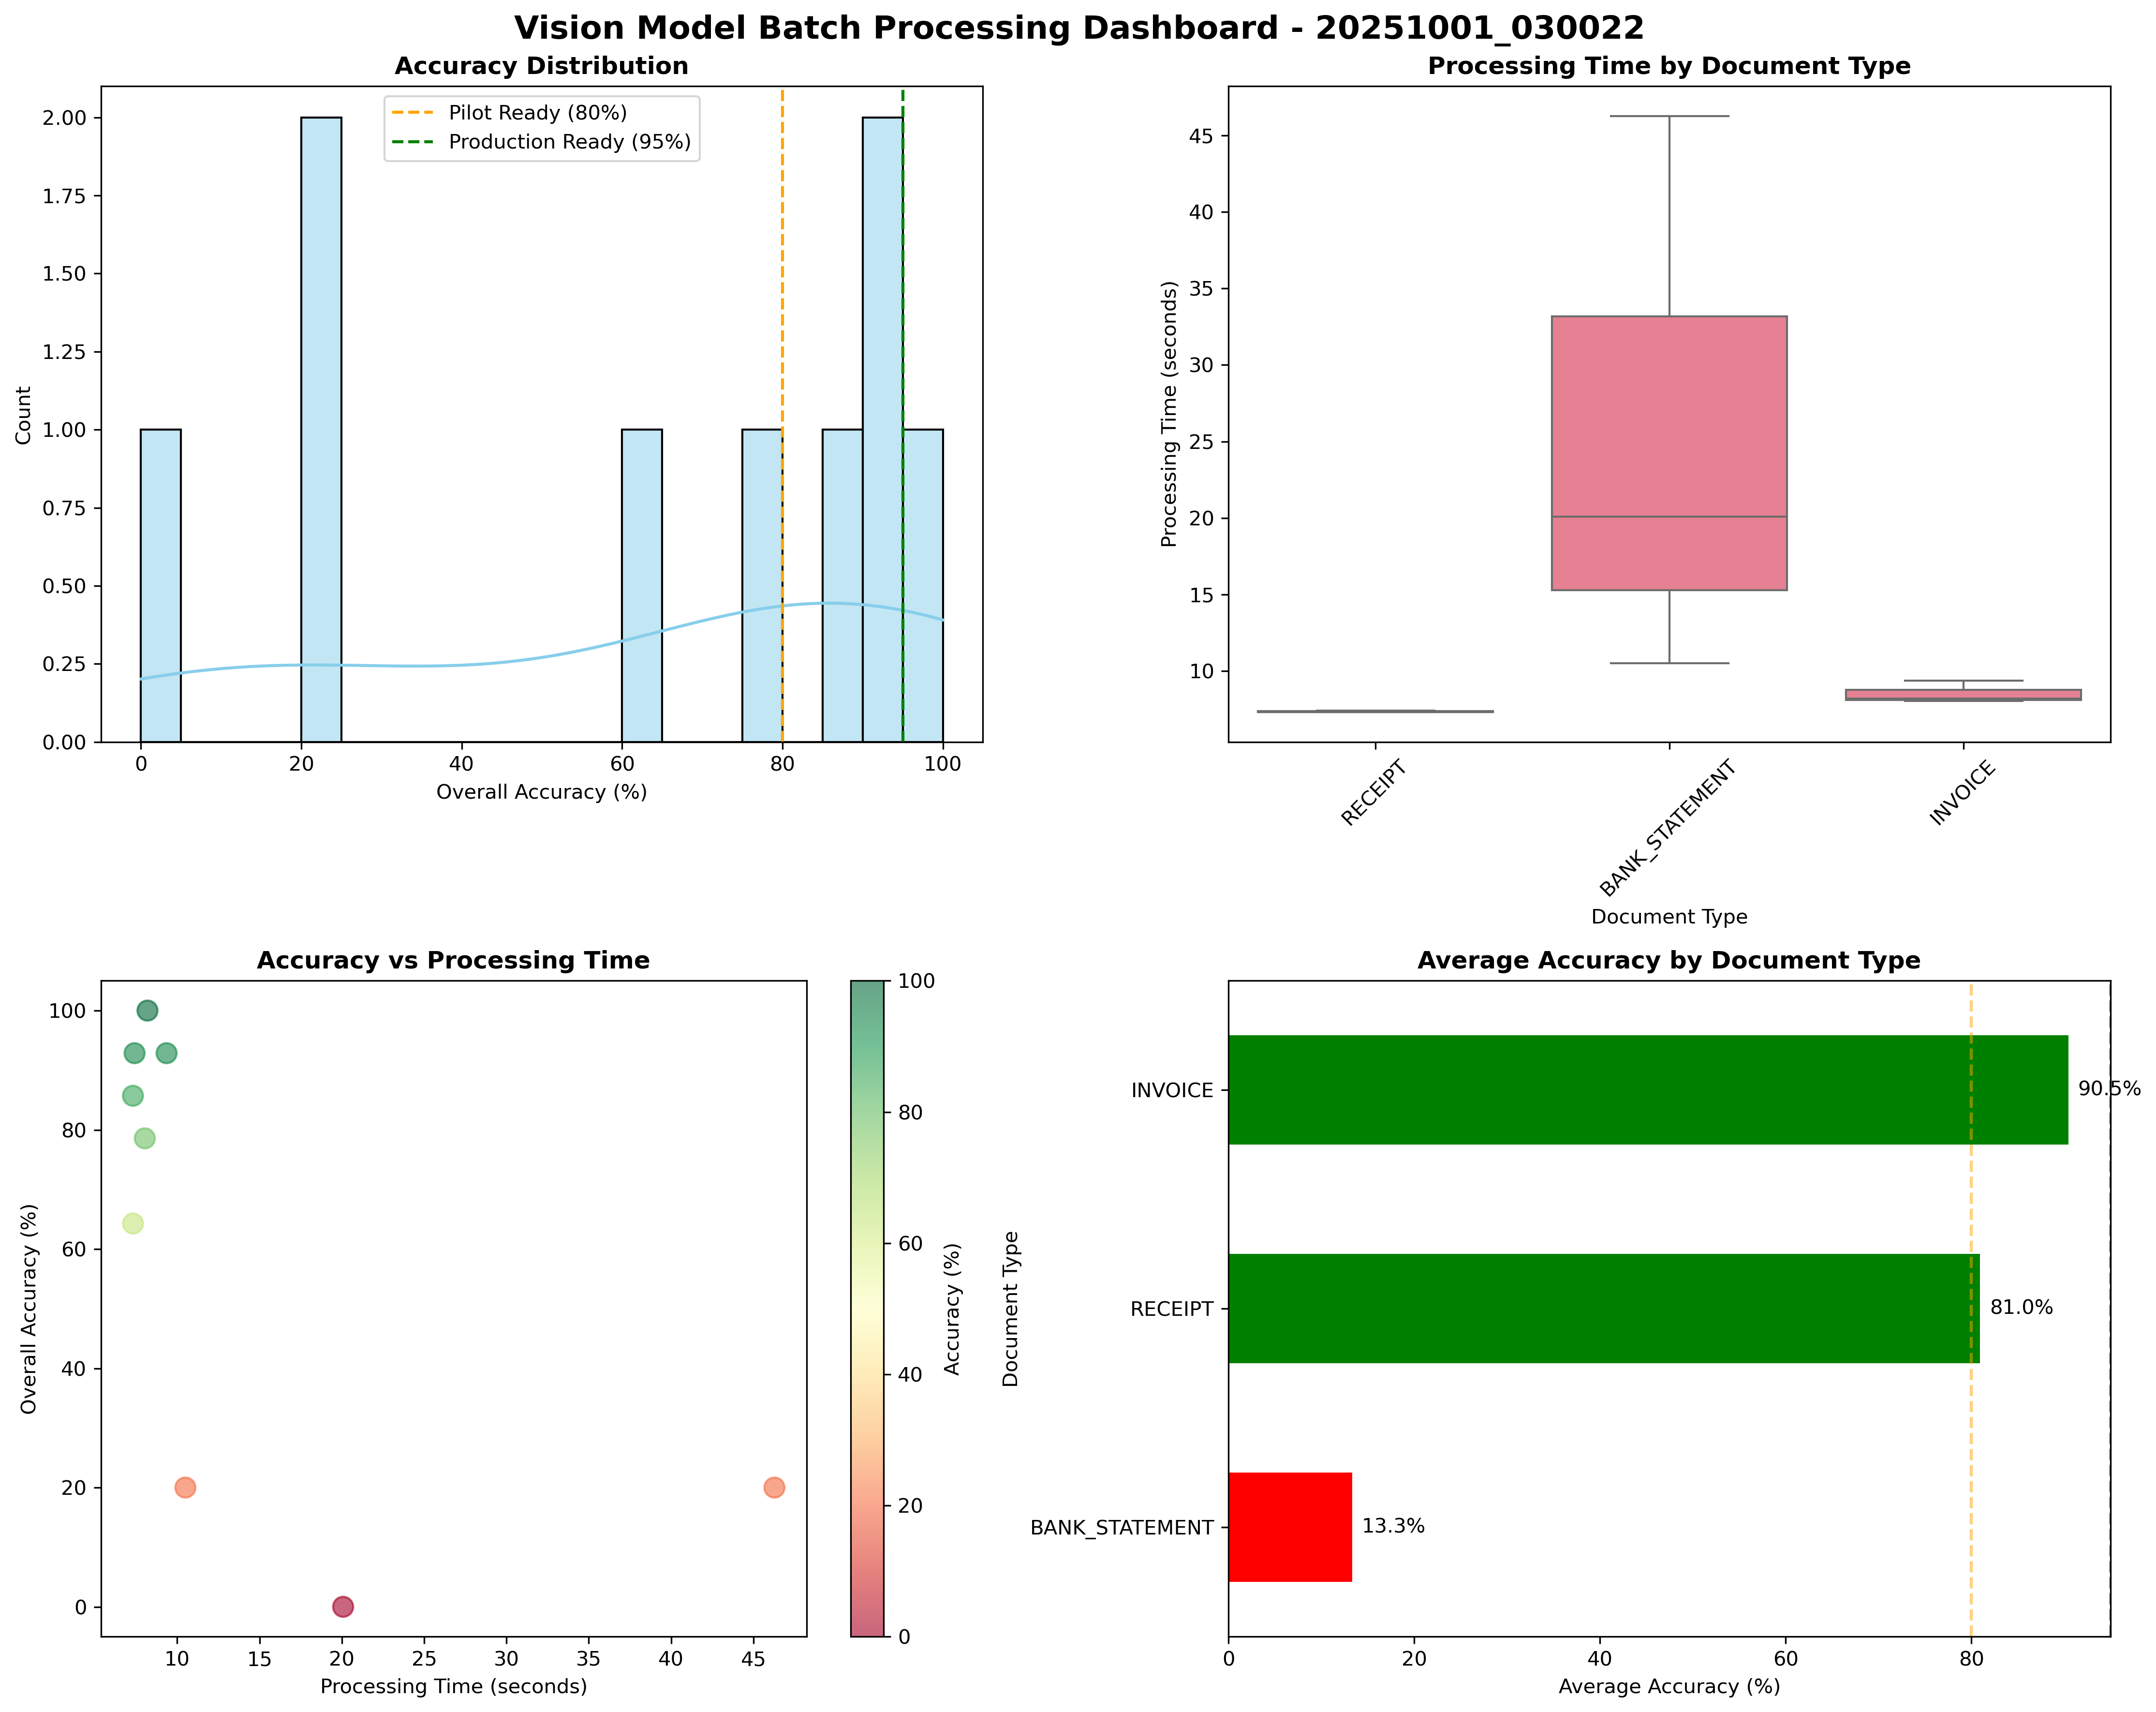

In [11]:
# Display final summary
console.rule("[bold green]Batch Processing Complete[/bold green]")

total_images = len(batch_results)
successful = len([r for r in batch_results if 'error' not in r])
avg_accuracy = df_results['overall_accuracy'].mean() if len(df_results) > 0 else 0

rprint(f"[bold green]✅ Processed: {total_images} images[/bold green]")
rprint(f"[cyan]Success Rate: {(successful/total_images*100):.1f}%[/cyan]")
rprint(f"[cyan]Average Accuracy: {avg_accuracy:.2f}%[/cyan]")
rprint(f"[cyan]Output: {OUTPUT_BASE}[/cyan]")

# Display dashboard if available
dashboard_files = list(OUTPUT_DIRS['visualizations'].glob(f"dashboard_{BATCH_TIMESTAMP}.png"))
if dashboard_files:
    dashboard_path = dashboard_files[0]
    rprint("\n[bold blue]📊 Visual Dashboard:[/bold blue]")
    display(Image(str(dashboard_path)))
else:
    rprint(f"\n[yellow]⚠️ Dashboard not found in {OUTPUT_DIRS['visualizations']}[/yellow]")